In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

import re
import pickle

from tqdm import tqdm

import torch
import flair
from flair.data import Sentence
from flair.embeddings import TransformerDocumentEmbeddings

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

import hdbscan
from umap import UMAP
import bertopic

In [2]:
torch._C._cuda_getDeviceCount()

1

In [3]:
torch.cuda.get_device_properties(torch.device)

_CudaDeviceProperties(name='GeForce RTX 2060', major=7, minor=5, total_memory=5934MB, multi_processor_count=30)

In [4]:
device = 'cuda' 
flair.device = device

In [5]:
query_pop_df = pd.read_csv('../data/csv/query_popularity.csv')
query_pop_df = query_pop_df.dropna()
query_pop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336987 entries, 0 to 336987
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   query             336987 non-null  object
 1   query_popularity  336987 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.7+ MB


In [6]:
def simple_text_clean(text, remove_small_things=False, remove_new_lines=True):
    result = re.sub(r'\n\n+', '\n', text, flags=re.MULTILINE)  # Убираем лишние разбивки строк
    result = re.sub(r'[\\x22]', '', text, flags=re.MULTILINE)  # Убираем какуюто гадость
    result = re.sub(r'[^А-Яа-я$"()%:.,\-\w\d\n\s]+', '', result, flags=re.MULTILINE)  # удаляем все ненужные символы
    if remove_new_lines:
        result = result.replace('\n', ' ')  # Замена символов переводов строк на пробелы
    if remove_small_things:
        result = re.sub(r'\b\w{1,3}\b', ' ', result, flags=re.MULTILINE)  # Удаляет слишком короткие слова
    result = re.sub(r'\s\s+', " ", result, flags=re.MULTILINE).strip()  # Удаление лишних пробелов
    return result

In [7]:
query_pop_df['query'] = query_pop_df['query'].str.lower()

In [8]:
web_site_regex = "^http(.*?)\/\/[a-z0-9-]{0,61}[.]{0,1}[a-z0-9-]{3,61}[.][a-z0-9-]{2,61}"
query_pop_df = query_pop_df.drop(query_pop_df[query_pop_df['query'].str.match(web_site_regex)].index)

In [9]:
digit_regex = "^[0-9.,-_]{1,}$"
query_pop_df = query_pop_df.drop(query_pop_df[query_pop_df['query'].str.match(digit_regex)].index)

In [10]:
query_pop_df['query'] = query_pop_df['query'].apply(simple_text_clean)

In [11]:
query_pop_df = query_pop_df.drop(query_pop_df[query_pop_df['query'].str.len() < 3].index)

In [12]:
query_pop_df = query_pop_df.drop_duplicates('query', keep='first')
query_pop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320694 entries, 0 to 336987
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   query             320694 non-null  object
 1   query_popularity  320694 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.3+ MB


In [13]:
scaler = MinMaxScaler((0.8, 1)) # можно поменять логику на (0, 1), и не домножнать на популярность а складывать

In [14]:
query_pop_df['query_popularity'] = scaler.fit_transform(query_pop_df['query_popularity'].values[:, np.newaxis])
query_pop_df.sample(10)

,query,query_popularity
280209,вибропуля вагинальная,0.822222
82474,подкова металлическая,0.955556
85515,платье красное деловое,0.955556
258883,бальзам для волос 500мл,0.844444
233727,англо русский словарь с транскрипцией,0.866667
268685,резиновая игрушка для собак,0.844444
160807,майка хоккейная,0.911111
58540,рюкзак кроватка,0.977778
206790,соки,0.866667
236673,ободок для девочки с цветами,0.844444


<AxesSubplot:>

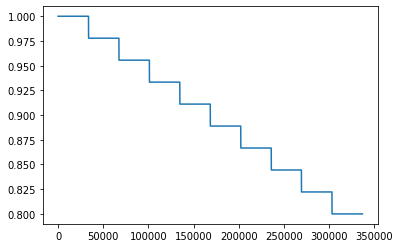

In [15]:
query_pop_df['query_popularity'].plot()

In [16]:
query_pop_df.to_csv('../data/fixed_query_popularity.csv')

In [14]:
sentences = query_pop_df['query'].apply(lambda x: Sentence(x))

In [16]:
embedder = TransformerDocumentEmbeddings('sentence-transformers/stsb-xlm-r-multilingual', fine_tune=False)

In [17]:
batch_size = 64

In [18]:
sentence_batches = [sentences[i * batch_size:(i + 1) * batch_size]
                    for i in range((len(sentences) + batch_size - 1) // batch_size)]

with tqdm(total=len(sentence_batches), desc='Batches') as progress_bar:
    for batch in sentence_batches:
        embedder.embed(batch)
        progress_bar.update(1) # update progress

Batches: 100%|██████████████████████████████████████████████████████████████████████| 5011/5011 [01:26<00:00, 58.26it/s]


In [19]:
documents = list(sentences.apply(lambda x: x.to_plain_string()).values)
embeddings = np.array(sentences.apply(lambda x: x.embedding.detach().cpu().numpy()).values.tolist())

In [20]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', low_memory=False)

In [21]:
umap_model.fit(embeddings) # скорее нужно для хранения в будущем чем для использования сейчвс

UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.0, n_components=5, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [22]:
reduced_emb = umap_model.transform(embeddings)
reduced_emb.shape

(320694, 5)

In [109]:
embeddings.nbytes

985171968

In [71]:
reduced_emb.nbytes

6413880

In [210]:
with open('../data/pickles/embeddings.pickle', 'wb') as f:
    pickle.dump(embeddings, f)

In [213]:
with open('../data/pickles/documents.pickle', 'wb') as f:
    pickle.dump(documents, f)

In [21]:
with open('../data/pickles/popularities.pickle', 'wb') as f:
    pickle.dump(query_pop_df['query_popularity'].values, f)

In [25]:
# with open('../pickles/popularities.pickle', 'rb') as f:
#     loaded = pickle.load(f)
# (query_pop_df['query_popularity'].values == loaded).all()

True

In [21]:
# pd.DataFrame({'documents': documents, 'embeddings': embeddings.tolist()}).to_csv('query_popularity_vectorized.csv') 

In [22]:
# embedded_df = pd.read_csv(query_popularity_vectorized.csv)

In [21]:
topic_model = bertopic.BERTopic(language='multilingual', calculate_probabilities=True, low_memory=False,
                       verbose=True, min_topic_size=8, n_gram_range=(1, 1), hdbscan_model=dbscan)

In [22]:
predictions, probabilities = topic_model.fit_transform(documents, embeddings)

2021-11-14 05:03:24,000 - BERTopic - Reduced dimensionality with UMAP


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
topic_model.get_topics()

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topic_model.save("popularity_topic_model")

In [77]:
search_hist_reader = pd.read_csv('../data/search_history.csv', engine='python')
search_hist_reader.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83919239 entries, 0 to 83919238
Data columns (total 6 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   wbuser_id  object
 1   UQ         object
 2   cnt        int64 
 3   locale     object
 4   weekday    int64 
 5   time       object
dtypes: int64(2), object(4)
memory usage: 3.8+ GB


In [82]:
len(search_hist_reader['wbuser_id'].unique())

8172206

In [91]:
search_hist_reader['UQ'] = search_hist_reader['UQ'].str.lower()

In [92]:
search_hist_reader = search_hist_reader.drop(search_hist_reader[search_hist_reader['UQ'].str.len() < 3].index)

In [94]:
search_hist_reader = search_hist_reader.dropna()

In [95]:
digit_regex = "^[0-9.,-_]{1,}$"
search_hist_reader = search_hist_reader.drop(search_hist_reader[search_hist_reader['UQ'].str.match(digit_regex)].index)

In [96]:
web_site_regex = "^http(.*?)\/\/[a-z0-9-]{0,61}[.]{0,1}[a-z0-9-]{3,61}[.][a-z0-9-]{2,61}"
search_hist_reader = search_hist_reader.drop(search_hist_reader[search_hist_reader['UQ'].str.match(web_site_regex)].index)

In [101]:
search_hist_reader['UQ'] = search_hist_reader['UQ'].apply(simple_text_clean)

In [102]:
search_hist_reader = search_hist_reader.drop(search_hist_reader[search_hist_reader['UQ'].str.len() < 3].index)

In [104]:
search_hist_reader.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83595083 entries, 0 to 83919238
Data columns (total 6 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   wbuser_id  object
 1   UQ         object
 2   cnt        int64 
 3   locale     object
 4   weekday    int64 
 5   time       object
dtypes: int64(2), object(4)
memory usage: 4.4+ GB


In [114]:
blabla = search_hist_reader[['UQ']].join(search_hist_reader.groupby('UQ', group_keys=False)['cnt'].median(), on='UQ')

In [122]:
blabla.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83595083 entries, 0 to 83919238
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   UQ      object 
 1   cnt     float64
dtypes: float64(1), object(1)
memory usage: 1.9+ GB


In [123]:
search_hist_reader['cnt'] = blabla['cnt'].astype(int)

In [124]:
search_hist_reader = search_hist_reader.drop_duplicates(['UQ', 'wbuser_id'], keep='first')

In [126]:
search_hist_reader.to_csv('../data/fixed_search_history.csv')

In [127]:
search_hist_reader.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31011049 entries, 0 to 83919234
Data columns (total 6 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   wbuser_id  object
 1   UQ         object
 2   cnt        int64 
 3   locale     object
 4   weekday    int64 
 5   time       object
dtypes: int64(2), object(4)
memory usage: 1.6+ GB


In [128]:
pd.to_datetime(search_hist_reader['time'])

0          2021-11-14 10:48:53
1          2021-11-14 10:48:53
2          2021-11-14 10:48:53
3          2021-11-14 10:48:53
4          2021-11-14 10:48:53
                   ...        
83919219   2021-11-14 23:30:40
83919225   2021-11-14 23:30:40
83919227   2021-11-14 23:30:40
83919229   2021-11-14 23:30:40
83919234   2021-11-14 23:30:40
Name: time, Length: 31011049, dtype: datetime64[ns]

In [131]:
# search_hist_reader['UQ']

In [188]:
test_sents = [Sentence(text) for text in search_hist_reader['UQ'].values[0:64]]

In [189]:
embedder.embed(test_sents)

[Sentence: "тапочки женские домашние"   [− Tokens: 3],
 Sentence: "чехол для бейджика"   [− Tokens: 3],
 Sentence: "guess"   [− Tokens: 1],
 Sentence: "штора для ванной"   [− Tokens: 3],
 Sentence: "фототфон"   [− Tokens: 1],
 Sentence: "туфли мужские осенние"   [− Tokens: 3],
 Sentence: "леггинсы женские"   [− Tokens: 2],
 Sentence: "чехол на айфон 11"   [− Tokens: 4],
 Sentence: "ботинки женские мембрана"   [− Tokens: 3],
 Sentence: "обувь женская оксфорды"   [− Tokens: 3],
 Sentence: "противоударный чехол на айфон 6"   [− Tokens: 5],
 Sentence: "зимняя обувь для мальчиков 37-38 размеров"   [− Tokens: 6],
 Sentence: "бисер"   [− Tokens: 1],
 Sentence: "робот змея"   [− Tokens: 2],
 Sentence: "костюм на флисе женский"   [− Tokens: 4],
 Sentence: "светящийся ошейник для собак"   [− Tokens: 4],
 Sentence: "изделия из мед сплава"   [− Tokens: 4],
 Sentence: "ремкомплект раздатки нива chevrolet"   [− Tokens: 4],
 Sentence: "оружие на лёго человека"   [− Tokens: 4],
 Sentence: "костюмы жен

In [203]:
test = np.random.choice(test_sents)
test.to_plain_string()

'противоударный чехол на айфон 6'

In [204]:
distances = cosine_similarity(test.embedding.detach().cpu().numpy()[np.newaxis, :], embeddings)
distances = distances * query_pop_df['query_popularity'].values

In [206]:
sentences.iloc[np.argsort(-distances)[:10][0]].apply(lambda x: x.to_plain_string()).head(20)

21043                 чехол на айфон 6s
22491                  чехол на айфон 6
41904       защитное стекло на айфон 6s
42385                 стекло на айфон 6
35255                    чехол айфон 6s
93542               чехол для айфона 6s
99163                чехол для айфон 6s
83537                   iphone 6s чехол
30874                    чехол на айфон
4944                   чехол на айфон r
74447        защитное стекло на айфон 6
5366                   чехол на айфон 7
9704                 адаптер для айфона
21877        защитное стекло на айфон 7
15225                 провод для айфона
10677    зарядное устройство для айфона
1602               iphone 1 pro ma 18gb
4893                           айфон se
25197                   кабель на айфон
17607              чехол на айфон 1 про
Name: query, dtype: object